# BPL_YEAST_AIR_Fedbatch demo

This notebook demonstrate yeast fedbatch cultivation. We look at impact of changes in the glucose feeding. We also take a look at tuning of the DO-control system. Both liquid- and gasphase are included in the model. 

Interaction with the compiled model as FMU is mainly through the simplified commands: par(), init(), newplot(), simu() etc. The last simulation is always available in the workspace and called 'sim_res'. The command describe() brings mainly up description infomration from the actual Modelica code from the FMU but is complemented with information given in the dedicated Python setup-file.

The idea is to demonstrate how simulations and varyiing conditions can provide some process insight that can support the experimetnal work. I hope that at the end of this session you are ready to formulate your own questions you want to address with simulations - and you can just go on in this notebook! Just press the field "+Code" in the upper left part of notebook interface and you get a new "cell" where you write your own code. You can copy and paste from cells above using ctrol-c and ctrl-p as usual and edit the cell. When your are ready to execute the cell just press the "play button" to the left in the cell or press shift-enter as in "ordinary" Jupyter notebooks.

After a session you may want to save your own notebook. That you can do on your Google Drive account and I refer to Colab instructions for how to do this. It is easy. 

Enjoy!

Now specific installation and the run simulations. Start with connecting to Github. Then upload the two files:

* FNU - BPL_YEAST_AIR_Fedbatch_linux_jm_cs.fmu
* Setup-file - BPL_YEAST_AIR_Fedbatch_explore

# Filter out DepracationWarnings for 'np.float as alias' is needed - wish I could make filter more narrow 
import warnings
warnings.filterwarnings("ignore")

%%bash 
git clone https://github.com/janpeter19/BPL_YEAST_AIR_Fedbatch

%cd BPL_YEAST_AIR_Fedbatch

In [1]:
run -i BPL_YEAST_AIR_Fedbatch_DOcontrol_explore.py

Linux - run FMU pre-comiled JModelica 2.4

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values / units

Note that both disp() and describe() takes values from the last simulation

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [2]:
plt.rcParams['figure.figsize'] = [36/2.54, 30/2.54]

In [3]:
describe('culture'); print(); describe('liquidphase'); print(); describe('gasphase')

Saccharomyces cerevisae - default parameters for strain H1022

Reactor broth substances included in the model

Cells   index       =  1 - molecular weight =  24.6 Da
Glucose index       =  2 - molecular weight =  180.0 Da
Ethanol index       =  3 - molecular weight =  46.0 Da
Dissolved O2 index  =  4 - molecular weight =  32.0 Da
Dissolved CO2 index =  5 - molecular weight =  44.0 Da

Reactor gasphase substances included in the model

N2 etc index  =  1 - molecular weight =  28.0 Da
O2 index      =  2 - molecular weight =  32.0 Da
CO2 index     =  3 - molecular weight =  44.0 Da
Ethanol index =  4 - molecular weight =  46.0 Da


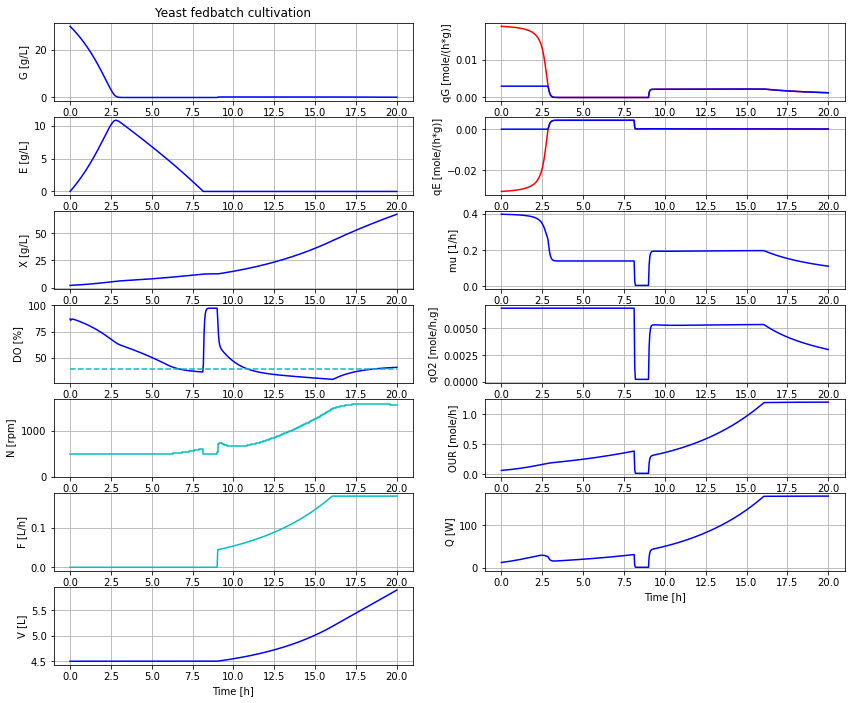

In [4]:
# Culture parameters and others at default values
par(qO2lim=0.0069) 

# Process initial conditions
init(V_0=4.5, VG_0=4.5*30, VX_0=4.5*2, VE_0=4.5*0) 

# Feed profile
par(t_start=9, F_start=0.044, mu_feed=0.20, F_max=0.18)  

# DO-control parameters
par(samplePeriod=1/60, K=10, Ti=0.5, I_0=500)   

# Simulate and plot
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
simu(20)

In [5]:
disp('culture', decimals=4)

qGmax : 0.02
Ks : 0.01
qO2lim : 0.0069


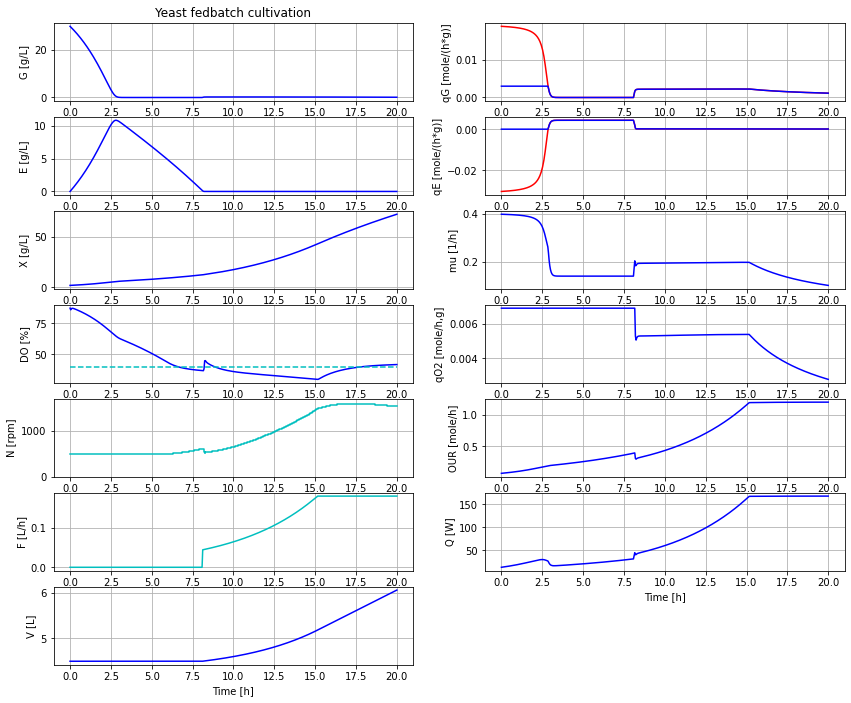

In [6]:
# Let us start the feeding just after the batch phase has ended and keep other parameters the same
par(t_start=8.1)

# Simulate and plot
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
simu(20)

The increase of DO to about 50 % at end of batch phase should be possible to detect easily. This simulation is more realistic and we use these settings from now on.

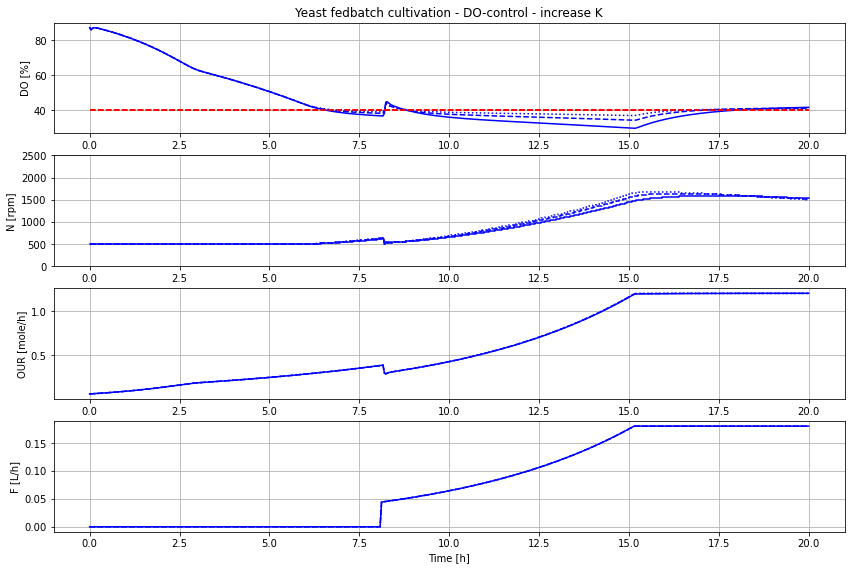

In [7]:
# Let us take a closer look at the DO-control system and try to make control error smaller by increaseing K
newplot(title='Yeast fedbatch cultivation - DO-control - increase K', plotType='Focus DO-control')
for value in [10, 20, 40]: par(K=value); simu(20)

# Reset K to the original value
par(K=10)

We see that by a higher control gain K the DO-control error get smaller and the stability of the control system is maintained.

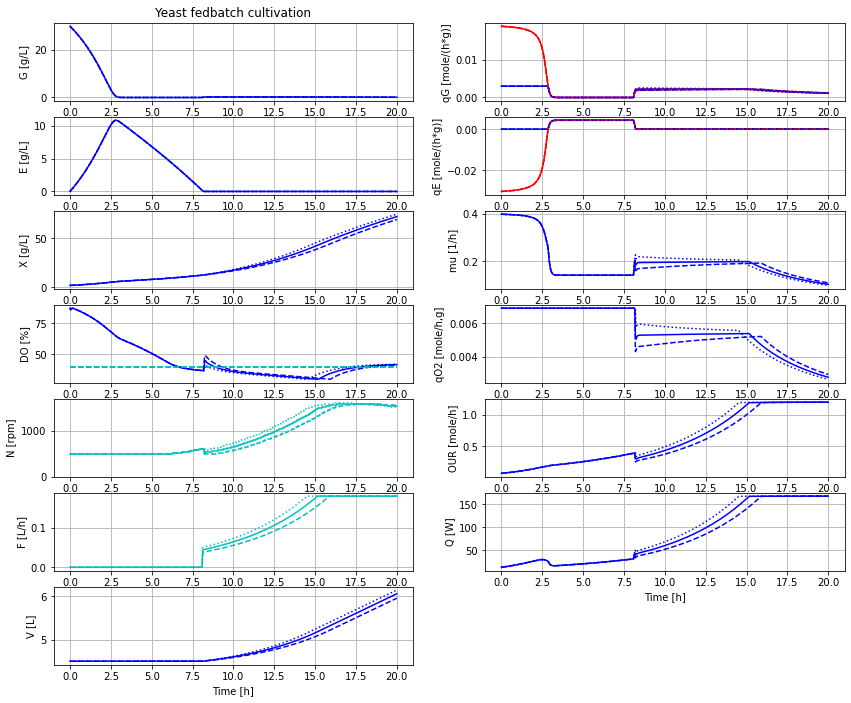

In [8]:
# Let us check the sensitivity to changes in the feed profile design
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
for value in [0.044, 0.038, 0.050]: par(F_start=value); simu(20)

The variation in F_start has an impact and we see that the actual growth rate during fedbatch phase do converge to the set growth rate of the feed, but i takes more than 5 hours.

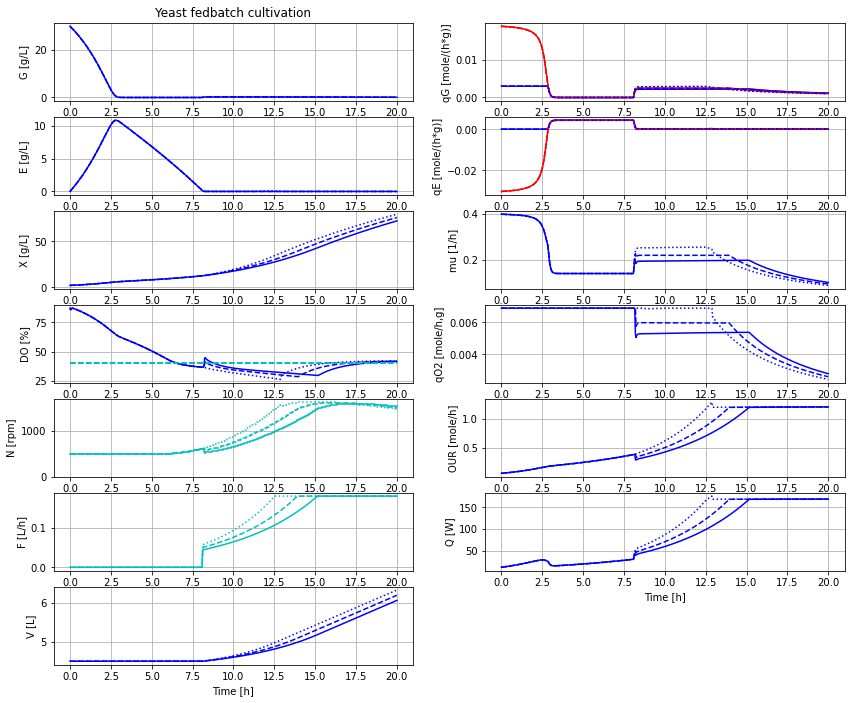

In [9]:
# Let us investigate a feedprofile that is closer to the maximal capacity
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
par(F_start=0.044, mu_feed=0.20); simu(20)
par(F_start=0.050, mu_feed=0.22); simu(20)
par(F_start=0.057, mu_feed=0.26); simu(20)

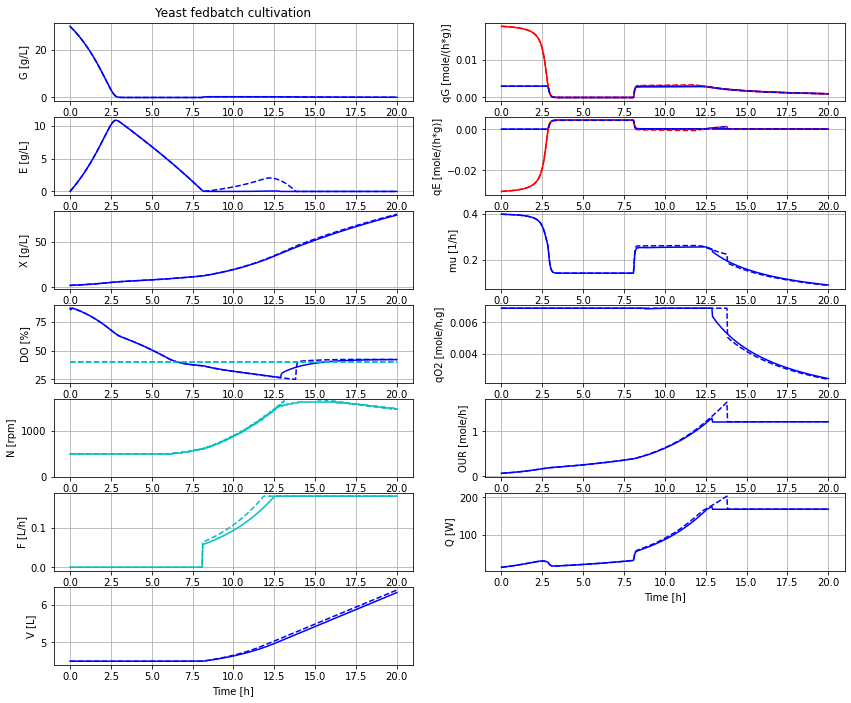

In [10]:
# And let us see what happens if the feedprofile exceed the culture capacity
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
par(F_start=0.057, mu_feed=0.26); simu(20)
par(F_start=0.063, mu_feed=0.28); simu(20)
par(F_start=0.044, mu_feed=0.20)

Note that with the feedprofile that exceed culture respiratory capacity, ethanol is accumulated during time 8-12.5 hours. When the feedprofile then is constant from time 12.5 hours and on, then the accumulated ethanol is consumed over about an hour. This leads to a higher oxygen demand and heat production during this time. The specific cell growth rate is also slightly higher during this period.

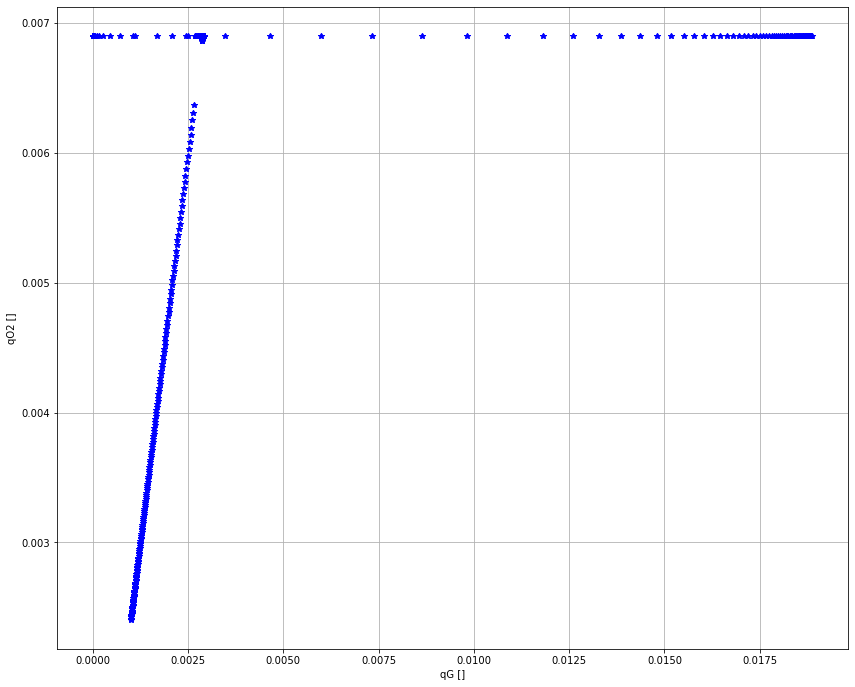

In [11]:
# Improvise and make your own diagram - study the relation qO2 vs qG(G) 

plt.figure()
ax1 = plt.subplot(1,1,1)
ax1.set_ylabel('qO2 []')
ax1.set_xlabel('qG []')
ax1.grid()

setLines()

diagrams.clear()
diagrams.append("ax1.plot(sim_res['bioreactor.culture.qGm'], sim_res['bioreactor.culture.qO2'], 'b*')")

par(F_start=0.057, mu_feed=0.26); simu(20)
simu(20)

In [12]:
# List of components in the process setup and also a couple of other things like liquidphase and gasphase etc
describe('parts')

['airFlow_setpoint', 'airtube', 'atmosphere', 'bioreactor', 'bioreactor.culture', 'bioreactor.gas_liquid_transfer', 'compressor', 'DO_setpoint', 'dosagescheme', 'DOsensor', 'feedtank', 'gasphase', 'liquidphase', 'MSL', 'N_high', 'N_low', 'PIreg', 'pump']


In [13]:
system_info()


System information
 -OS: Linux
 -Python: 3.8.2
 -PyFMI: 2.7.4
 -FMU by: JModelica.org
 -FMI: 2.0
 -Type: FMUModelCS2
 -Name: BPL_YEAST_AIR.Fedbatch_DOcontrol
 -Generated: 2022-08-26T11:07:26
 -MSL: 3.2.2 build 3
 -Description: Bioprocess Library version 2.1.0 beta
 -Interaction: FMU-explore ver 0.9.2
